<div align=center>
<h1>Comment démasquer les fraudeurs ?</h1>
<h2>par BNP Paribas PF</h2>
<h3>MICHELON François</h3>
<h3>ZABLIT Charles</h3>
</div>


# 0. Configuration


## 0.1 Imports de modules


In [1]:
import logging
import pathlib
import re
from typing import Tuple, List
from collections import Counter

import gensim.downloader as api
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import sklearn.linear_model as linear_model
from sklearn.model_selection import (
    GridSearchCV,
    train_test_split,
    StratifiedShuffleSplit,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import sklearn.svm as svm
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer

## 0.2 Configuration du logger


In [2]:
# Initialize logger
logging.basicConfig(level=logging.INFO)

## 0.3 Configuration des chemins de fichiers


In [3]:
X_train_file = pathlib.Path("data/X_train_G3tdtEn.csv")
y_train_file = pathlib.Path("data/Y_train_2_XPXJDyy.csv")
X_test_file = pathlib.Path("data/X_test_8skS2ey.csv")

# 1. Analyse des données


## 1.1 Chargement des données


In [4]:
def load_train_df(path: pathlib.Path) -> pd.DataFrame:
    mixed_columns = (
        ["item" + str(i) for i in range(1, 25)]
        + ["make" + str(i) for i in range(1, 25)]
        + ["model" + str(i) for i in range(1, 25)]
        + ["goods_code" + str(i) for i in range(1, 25)]
    )
    dtype = {col: str for col in mixed_columns}
    return pd.read_csv(path, dtype=dtype)


def load_test_df(path: pathlib.Path) -> pd.Series:
    return pd.read_csv(path)["fraud_flag"]

In [5]:
X_train_df = load_train_df(X_train_file)
y_train_df = load_test_df(y_train_file)
X_test_df = load_train_df(X_test_file)

In [6]:
X_train_df.head()

,ID,item1,item2,item3,item4,item5,item6,item7,item8,item9,...,Nbr_of_prod_purchas16,Nbr_of_prod_purchas17,Nbr_of_prod_purchas18,Nbr_of_prod_purchas19,Nbr_of_prod_purchas20,Nbr_of_prod_purchas21,Nbr_of_prod_purchas22,Nbr_of_prod_purchas23,Nbr_of_prod_purchas24,Nb_of_items
0,85517,COMPUTERS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,51113,COMPUTER PERIPHERALS ACCESSORIES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,83008,TELEVISIONS HOME CINEMA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,78712,COMPUTERS,COMPUTER PERIPHERALS ACCESSORIES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
4,77846,TELEVISIONS HOME CINEMA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [7]:
X_train_df.describe()

,ID,cash_price1,cash_price2,cash_price3,cash_price4,cash_price5,cash_price6,cash_price7,cash_price8,cash_price9,...,Nbr_of_prod_purchas16,Nbr_of_prod_purchas17,Nbr_of_prod_purchas18,Nbr_of_prod_purchas19,Nbr_of_prod_purchas20,Nbr_of_prod_purchas21,Nbr_of_prod_purchas22,Nbr_of_prod_purchas23,Nbr_of_prod_purchas24,Nb_of_items
count,92790.000000,92790.000000,44656.000000,12901.000000,4562.000000,2170.00000,1336.000000,946.000000,727.000000,568.000000,...,165.000000,142.000000,120.000000,103.000000,91.000000,77.000000,63.000000,50.000000,43.000000,92790.000000
mean,57968.969070,1093.907124,191.608071,193.334548,176.132398,195.73871,162.015719,144.598309,130.957359,132.609155,...,1.290909,1.436620,1.466667,1.388350,1.329670,1.220779,1.380952,1.160000,1.372093,1.764479
std,33487.595782,711.172270,392.665621,375.676640,321.354938,374.22739,292.077355,291.432858,257.730692,267.234057,...,0.749131,1.431484,1.810025,1.165122,0.869929,0.528737,0.923328,0.548095,1.113195,1.462264
min,0.000000,2.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,28901.250000,649.000000,7.000000,7.000000,10.000000,16.00000,15.000000,20.000000,16.000000,18.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,57961.500000,949.000000,40.000000,43.000000,48.000000,59.00000,50.000000,50.000000,45.000000,45.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,86985.750000,1349.000000,139.000000,189.000000,189.000000,199.00000,179.250000,140.000000,120.000000,129.250000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.500000,1.000000,1.000000,2.000000
max,115985.000000,21995.000000,6499.000000,5999.000000,5198.000000,4249.00000,2997.000000,4198.000000,2999.000000,2399.000000,...,6.000000,12.000000,16.000000,7.000000,7.000000,4.000000,7.000000,4.000000,8.000000,60.000000


## 1.2 Étude de la parcimonie des données


In [9]:
def sparse_coeff(X: pd.DataFrame) -> float:
    nb_sparse = X_train_df.isnull().sum().sum()
    nb_total = X_train_df.shape[0] * X_train_df.shape[1]
    return nb_sparse / nb_total


print(f"{sparse_coeff(X_train_df):.2%} des données sont nulles.")

91.41% des données sont nulles.


Text(0.5, 1.0, 'Répartition des items non nuls')

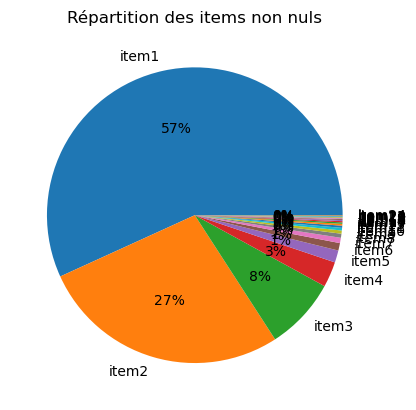

In [10]:
X_train_df.notnull().sum()[[f"item{i}" for i in range(1, 25)]].plot.pie(
    autopct="%1.0f%%",
)
plt.xticks(rotation=45)
plt.title("Répartition des items non nuls")

92% des commandes ont moins de 3 items.


## 1.3 Étude des tendances


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'item5'),
  Text(1, 0, 'item6'),
  Text(2, 0, 'item7'),
  Text(3, 0, 'item8'),
  Text(4, 0, 'item9'),
  Text(5, 0, 'item10'),
  Text(6, 0, 'item11'),
  Text(7, 0, 'item12'),
  Text(8, 0, 'item13'),
  Text(9, 0, 'item14'),
  Text(10, 0, 'item15'),
  Text(11, 0, 'item16'),
  Text(12, 0, 'item17'),
  Text(13, 0, 'item18'),
  Text(14, 0, 'item19'),
  Text(15, 0, 'item20'),
  Text(16, 0, 'item21'),
  Text(17, 0, 'item22'),
  Text(18, 0, 'item23'),
  Text(19, 0, 'item24')])

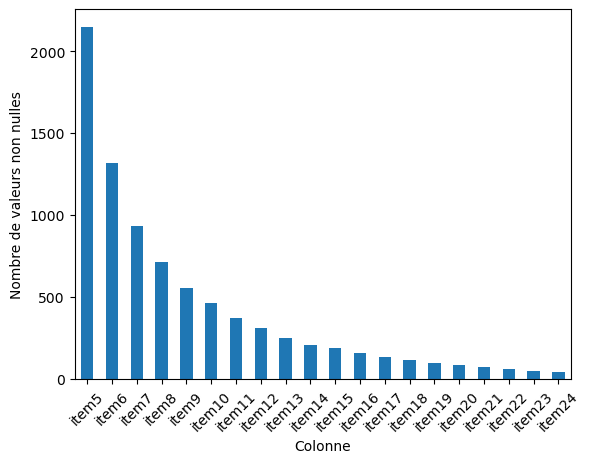

In [11]:
X_train_df[y_train_df == 0].notnull().sum()[
    [f"item{i}" for i in range(5, 25)]
].plot.bar()
plt.ylabel("Nombre de valeurs non nulles")
plt.xlabel("Colonne")
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'item5'),
  Text(1, 0, 'item6'),
  Text(2, 0, 'item7'),
  Text(3, 0, 'item8'),
  Text(4, 0, 'item9'),
  Text(5, 0, 'item10'),
  Text(6, 0, 'item11'),
  Text(7, 0, 'item12'),
  Text(8, 0, 'item13'),
  Text(9, 0, 'item14'),
  Text(10, 0, 'item15'),
  Text(11, 0, 'item16'),
  Text(12, 0, 'item17'),
  Text(13, 0, 'item18'),
  Text(14, 0, 'item19'),
  Text(15, 0, 'item20'),
  Text(16, 0, 'item21'),
  Text(17, 0, 'item22'),
  Text(18, 0, 'item23'),
  Text(19, 0, 'item24')])

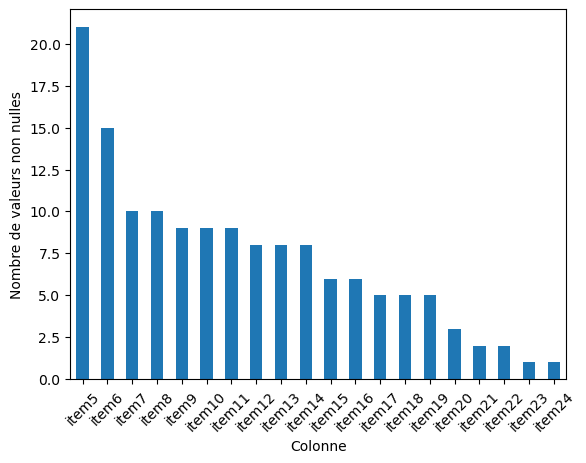

In [12]:
X_train_df[y_train_df == 1].notnull().sum()[
    [f"item{i}" for i in range(5, 25)]
].plot.bar()
plt.ylabel("Nombre de valeurs non nulles")
plt.xlabel("Colonne")
plt.xticks(rotation=45)

En regardant pour les colonnes items > 5, fraude+non fraude et fraude, on n'observe pas de tendance sur le nombre d'items par panier entre les commandes frauduleuses et les non frauduleuses.

---


(array([-5.,  0.,  5., 10., 15., 20., 25., 30.]),
 [Text(-5.0, 0, '−5'),
  Text(0.0, 0, '0'),
  Text(5.0, 0, '5'),
  Text(10.0, 0, '10'),
  Text(15.0, 0, '15'),
  Text(20.0, 0, '20'),
  Text(25.0, 0, '25'),
  Text(30.0, 0, '30')])

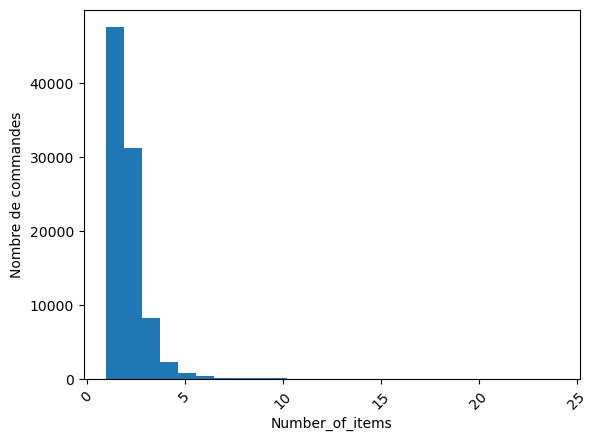

In [13]:
X_train_df[(y_train_df == 0) & (X_train_df["Nb_of_items"] < 25)][
    "Nb_of_items"
].plot.hist(bins=25)
plt.ylabel("Nombre de commandes")
plt.xlabel("Number_of_items")
plt.xticks(rotation=45)

(array([-5.,  0.,  5., 10., 15., 20., 25., 30.]),
 [Text(-5.0, 0, '−5'),
  Text(0.0, 0, '0'),
  Text(5.0, 0, '5'),
  Text(10.0, 0, '10'),
  Text(15.0, 0, '15'),
  Text(20.0, 0, '20'),
  Text(25.0, 0, '25'),
  Text(30.0, 0, '30')])

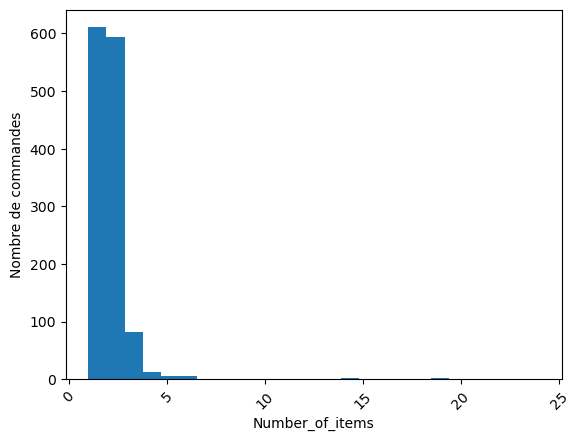

In [14]:
X_train_df[y_train_df == 1]["Nb_of_items"].plot.hist(bins=25)
plt.ylabel("Nombre de commandes")
plt.xlabel("Number_of_items")
plt.xticks(rotation=45)

Là encore, on ne distingue pas de tendance significatives sur la distribution du nombre d'items par panier.

---


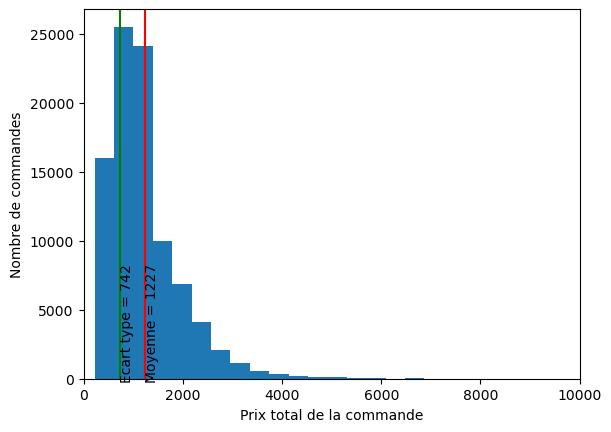

In [15]:
def total_price(X: pd.DataFrame) -> pd.Series:
    return X[[f"cash_price{i}" for i in range(1, 25)]].sum(axis=1)


def plot_total_price_hist(X: pd.DataFrame, y: pd.DataFrame, fraud: bool) -> None:
    if fraud:
        total_price_df = total_price(X[(total_price(X) < 10000) & (y == 1)])
    else:
        total_price_df = total_price(X[(total_price(X) < 10000) & (y == 0)])
    total_price_df.plot.hist(bins=25)
    mean = total_price_df.mean()
    std = total_price_df.std()
    plt.xlim(0, 10000)
    plt.axvline(
        x=mean,
        color="red",
    )
    plt.text(mean, 0, f"Moyenne = {mean:.0f}", rotation=90)
    plt.axvline(
        x=std,
        color="green",
    )
    plt.text(std, 0, f"Ecart type = {std:.0f}", rotation=90)
    plt.ylabel("Nombre de commandes")
    plt.xlabel("Prix total de la commande")


plot_total_price_hist(X_train_df, y_train_df, fraud=False)

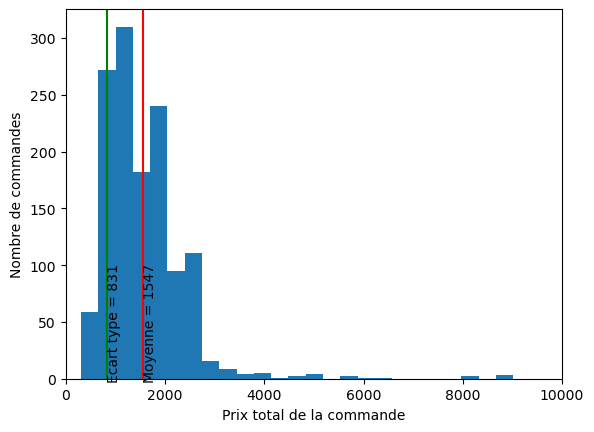

In [16]:
plot_total_price_hist(X_train_df, y_train_df, fraud=True)

On observe une légère augmentation de la moyenne et de l'écart type du prix total des commandes pour les fraudes. Nous allons essayer d'utiliser ces informations dans nos features.


## 1.4 Étude de la distribution des classes


Text(0, 0.5, '')

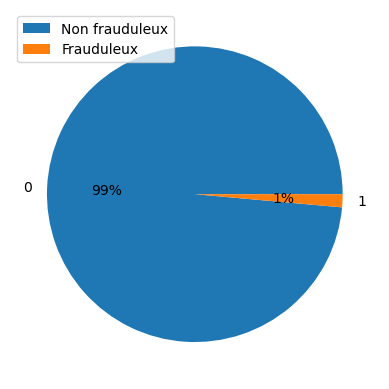

In [17]:
y_train_df.value_counts().plot.pie(
    autopct="%1.0f%%",
)
plt.legend(["Non frauduleux", "Frauduleux"])
plt.ylabel("")

C'est un jeux de données de détection de fraudes, donc la distribution frauduleux/non frauduleux est très inégale.


# 2. Feature engineering


## 2.1 Création de nouvelles features


In [28]:
class FeaturesExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X: pd.DataFrame, y=None):
        df = X
        # Create a column with the total price of the purchase.
        df["total_price"] = df[[f"cash_price{i}" for i in range(1, 25)]].sum(axis=1)
        # Create a column with the average price of the items in the purchase.
        df["avg_item_price"] = df["total_price"] / df["Nb_of_items"]
        # Create a column with the maximum price of the items in the purchase.
        df["max_item_price"] = df[[f"cash_price{i}" for i in range(1, 25)]].max(axis=1)
        # Create a column with the minimum price of the items in the purchase.
        df["min_item_price"] = df[[f"cash_price{i}" for i in range(1, 25)]].min(axis=1)
        # Create a column with the variance of the prices of the items in the purchase.
        df["price_variance"] = df[[f"cash_price{i}" for i in range(1, 25)]].var(axis=1)
        # Create a column with the number of products in the purchase.
        df["product_count"] = df[[f"Nbr_of_prod_purchas{i}" for i in range(1, 25)]].sum(
            axis=1
        )
        # Create a column with the number of unique manufacturers in the purchase.
        df["nb_unique_makes"] = df[[f"make{i}" for i in range(1, 25)]].nunique(axis=1)
        # Create a column with the number of unique items in the purchase.
        df["nb_unique_models"] = df[[f"model{i}" for i in range(1, 25)]].nunique(axis=1)
        # Create a column of the ratio of items to products in the purchase.
        df["item_to_product_ratio"] = df["Nb_of_items"] / df["product_count"]
        # Create a column of the most common item in the purchase.
        df["most_common_item"] = df[
            [f"Nbr_of_prod_purchas{i}" for i in range(1, 25)]
        ].idxmax(axis=1)
        most_common_item = []
        for _, row in df.iterrows():
            match = re.search(r"(\d+)", row["most_common_item"])
            item_number = int(match.group(1))
            most_common_item.append(row[f"item{item_number}"])
        df["most_common_item"] = most_common_item
        df["most_common_item"] = df["most_common_item"].astype(str)

        # For each goods_code, count the number of times it appears in the dataset.
        all_goods = []
        for _, row in df.iterrows():
            for i in range(1, 25):
                all_goods.append(row[f"goods_code{i}"])
        goods_counter = Counter(all_goods)
        for index, row in df.iterrows():
            for i in range(1, 25):
                if isinstance(row[f"goods_code{i}"], str):
                    df.at[index, f"goods_code{i}"] = goods_counter[
                        row[f"goods_code{i}"]
                    ]
                else:
                    df.at[index, f"goods_code{i}"] = 0
        df[["goods_code" + str(i) for i in range(1, 25)]] = df[
            ["goods_code" + str(i) for i in range(1, 25)]
        ].astype(int)

        # Identify the columns to apply RNN tokenization
        categorical_columns = ["make", "item", "model"]  # Add more columns as needed
        categorical_columns = [
            col + str(i) for col in categorical_columns for i in range(1, 25)
        ]
        categorical_columns.append("most_common_item")

        # Identify the categorical and numerical columns
        numerical_columns = [
            col for col in df.columns if col not in set(categorical_columns)
        ]

        # Clean data
        for col in categorical_columns:
            df[col] = df[col].fillna("")
        for col in numerical_columns:
            df[col] = df[col].fillna(0)

        return df

## 2.2 Transformer Word2Vec


In [20]:
class Word2Vec(BaseEstimator, TransformerMixin):
    def __init__(self, num_words=None, **kwargs):
        self.num_words = num_words
        self.tokenizer = Tokenizer(num_words=num_words, **kwargs)

    def fit(self, X, y=None):
        self.Word2 = api.load("word2vec-google-news-300")
        return self

    def transform(self, X, y=None):
        x = np.array(X.values)
        for i in range(len(x)):
            for j in range(len(x[i])):
                tokens = x[i][j].split()
                embeddings = [
                    self.Word2[token]
                    for token in tokens
                    if token in self.Word2.key_to_index
                ]
                if len(embeddings) > 0:
                    mean = np.mean(embeddings)
                else:
                    mean = 0
                x[i][j] = mean
        return x

    def get_params(self, deep=True):
        return {"num_words": self.num_words}

## 2.3 Définition de la pipeline


In [37]:
def get_column_types(X: pd.DataFrame) -> Tuple[List[str], List[str]]:
    text_columns = ["make", "item", "model"]
    text_columns = [f"{col}{i}" for col in text_columns for i in range(1, 25)]
    text_columns.append("most_common_item")
    num_columns = [col for col in X.columns if col not in set(text_columns)]

    return text_columns, num_columns


def generate_static_pipeline(X: pd.DataFrame) -> Pipeline:
    text_columns, _ = get_column_types(X)

    preprocessor = ColumnTransformer(
        transformers=[
            ("column_dropper", "drop", ["ID"]),
            ("cat_pipeline", Word2Vec(), text_columns),
        ],
        remainder="passthrough",
    )

    return Pipeline(
        steps=[
            ("features_extract", FeaturesExtractor()),
            ("preprocess_static", preprocessor),
        ]
    )

## 2.4 Étude de la corrélation des données


In [42]:
def label_corr(X: np.ndarray, y: pd.Series) -> pd.DataFrame:
    columns = (
        [f"item{i}" for i in range(1, 25)]
        + [f"cash_price{i}" for i in range(1, 25)]
        + [f"make{i}" for i in range(1, 25)]
        + [f"model{i}" for i in range(1, 25)]
        + [f"goods_code{i}" for i in range(1, 25)]
        + [f"Nbr_of_prod_purchas{i}" for i in range(1, 25)]
        + [
            "Nb_of_items",
            "total_price",
            "avg_item_price",
            "max_item_price",
            "min_item_price",
            "price_variance",
            "product_count",
            "nb_unique_makes",
            "nb_unique_models",
            "item_to_product_ratio",
            "most_common_item",
        ]
    )
    df = pd.DataFrame(
        X,
        columns=columns,
    )
    df["fraud_flag"] = y
    return df.corr()[y.name].abs().sort_values(ascending=False)


label_corr(
    generate_static_pipeline(X_train_df).fit_transform(X_train_df, y_train_df),
    y_train_df,
).head(15)

INFO:gensim.models.keyedvectors:loading projection weights from /Users/charles/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz
INFO:gensim.utils:KeyedVectors lifecycle event {'msg': 'loaded (3000000, 300) matrix of type float32 from /Users/charles/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz', 'binary': True, 'encoding': 'utf8', 'datetime': '2023-11-23T12:05:56.215365', 'gensim': '4.3.0', 'python': '3.10.13 (main, Sep 11 2023, 08:24:56) [Clang 14.0.6 ]', 'platform': 'macOS-14.0-arm64-arm-64bit', 'event': 'load_word2vec_format'}


# 3. Entraînement du modèle


## 3.1 Tuning des hyperparamètres


In [53]:
grid = GridSearchCV(
    RandomForestClassifier(random_state=0),
    param_grid={
        "bootstrap": [True],
    },
    scoring="average_precision",
    cv=StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0),
    n_jobs=-1,
    verbose=True,
)

## 3.2 Split des données


In [54]:
X_train, X_test, y_train, y_test = train_test_split(
    X_train_df, y_train_df, test_size=0.2, stratify=y_train_df, random_state=0
)
print(f"{y_train.value_counts()[1] / len(y_train):.5%} de fraudes dans le train set.")
print(f"{y_test.value_counts()[1] / len(y_test):.5%} de fraudes dans le test set.")

1.42122% de fraudes dans le train set.
1.42257% de fraudes dans le test set.


## 3.3 Entraînement du modèle


In [55]:
X_train = generate_static_pipeline(X_train_df).fit_transform(X_train, y_train)
grid.fit(X_train, y_train)

INFO:gensim.models.keyedvectors:loading projection weights from /Users/charles/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz
INFO:gensim.utils:KeyedVectors lifecycle event {'msg': 'loaded (3000000, 300) matrix of type float32 from /Users/charles/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz', 'binary': True, 'encoding': 'utf8', 'datetime': '2023-11-23T12:09:31.039460', 'gensim': '4.3.0', 'python': '3.10.13 (main, Sep 11 2023, 08:24:56) [Clang 14.0.6 ]', 'platform': 'macOS-14.0-arm64-arm-64bit', 'event': 'load_word2vec_format'}


Fitting 1 folds for each of 1 candidates, totalling 1 fits


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=1, random_state=0, test_size=0.2,
            train_size=None),
             estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'bootstrap': [True]}, scoring='average_precision',
             verbose=True)

In [56]:
print(f"Meilleurs paramètres du GridSearch: {grid.best_params_}")
print(f"Meilleur score du GridSearch: {grid.best_score_:0.5%}")

Meilleurs paramètres du GridSearch: {'bootstrap': True}
Meilleur score du GridSearch: 16.58984%


## 3.4 Pipeline finale


In [ ]:
pipeline = make_pipeline(
    generate_static_pipeline(X_train_df),
    RandomForestClassifier(random_state=0, n_jobs=-1, **grid.best_params_),
)

## 3.5 Évaluation


In [ ]:
pipeline.fit(X_train_df, y_train_df)

In [ ]:
print(
    f"Average precision score: {metrics.average_precision_score(y_test, pipeline.predict_proba(X_test)[:, 1]):.4%}"
)
metrics.PrecisionRecallDisplay.from_estimator(
    pipeline, X_test, y_test, name="RandomForest", plot_chance_level=True
)

## 3.6 Prédiction sur les données de test


In [13]:
out = pipeline.fit(X_train_df, y_train_df).predict_proba(X_test_df)
out_ = out[:, 1]
IDs = pd.read_csv(X_test_file)["ID"]
df = pd.DataFrame({"ID": IDs, "fraud_flag": out_})
df = df.reset_index()
df.to_csv("out.csv", index=False)
df.describe()

INFO:gensim.models.keyedvectors:loading projection weights from /Users/charles/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz
INFO:gensim.utils:KeyedVectors lifecycle event {'msg': 'loaded (3000000, 300) matrix of type float32 from /Users/charles/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz', 'binary': True, 'encoding': 'utf8', 'datetime': '2023-11-23T09:13:03.313449', 'gensim': '4.3.0', 'python': '3.10.13 (main, Sep 11 2023, 08:24:56) [Clang 14.0.6 ]', 'platform': 'macOS-14.0-arm64-arm-64bit', 'event': 'load_word2vec_format'}
